# Identifying Similar Graphic Design Templates

![Graphic Design](images/design_describer.jpg)


# The Aim

Several companies are springing up that offer ready-made graphic design templates,
in categories such as business cards, invitations and presentations. These kind of templates
all similar in a sense, but there is lots of variation between them that makes some
likable to one user, and unlikable to another. For example all birthday invitations
have similar words on them _"You're invited to my birthday ... it's on YYYY-MM-DD"_
but there's many different layouts, colours and graphics that make it personalised.

With the more templates being created, it is easy to get overwhelmed, close the browser and
give up on trying to find one you like. Can this experience be improved? Is it possible
to offer up suggestions of what a user may like based on what they click on?
Rather than a user clicking through Page 1 up to Page 100, could they go down a rabbit-hole
of suggested templates, slowly refining it down until they find the one they want?

The aim of this little project is to see if we can offer up similar graphic design templates
based on an input template. There has been work done in the past on finding similar songs
based on an input song ([link](https://github.com/spotify/annoy)) and on finding similar
photographs ([link](https://www.kaggle.com/abhikjha/fastai-hooks-and-image-similarity-search)).
Can we extend that same approach to design templates?

(Click [here](#results) if you want to skip to the end and see the results.)

# The Method

The basic principle that both methods listed above use is to generate a list of numeric values that can describe
each object. Finding "similar" templates is then about selecting out the templates that have the lowest overall difference
between its numeric features and the original object's. Another way to think of this is plotting the object into multi-dimensional space, and selecting out the other objects that are "closest" to it.

For our project we narrowed down on a specific type of graphic design templates: **invitations**.

There are different ways to construct a "Numeric Feature Generator" <sup>TM</sup> for invitations.

The first is to think about different metrics that would define a graphic design. For example, they could be broken into three categories: the text used, the graphics added and the overall layout. The text might be large/small, sans-serif/script. The graphics might be vector-based/hand-drawn, floral/industrial. The layout might be minimal/crowded. With a set of metrics you could label each of your graphics with that information. It would be hard if you don't have the individual elements available. If you could pull it off, the benefit is that these numbers are very explainable to a person off the street.

I didn't have access to this kind of info so had to make do with something else. I tried to let a machine learn the key features of a design and see if it was _good enough_ for finding similar graphics. This approach involves setting a machine to learn the images with the task of trying to classify invitations based on their type: weddings, birthdays, bbqs and graduations. As part of that process, the very last stage before the machine will output it's prediction, it generates a 500-length list of numeric features that it weighs up to make it's final decision. Ignoring it's final prediction, pulling this 500-length vector for each of the invitations would do well as a list of numeric features.

# The Data

I needed to get a set of images of invitations. A well-worded google search and a web scrape meant I was able to
get around 150 images per category (bbq, wedding, birthday, graduation). There's lots of noise in google search so doing something like `"birthday invitations site:canva.com"` did the job. Note that there is still some duplicate results from doing a search like this. On a version-2 of this project these exact duplicates can be removed using something like
[this](https://pypi.org/project/ImageHash/). We leave them in for now.

The benefit of includes labels in the google search is that we get the image labelling for free; all images downloaded in each search can be matched to their category.

The files are hosted at www.kaggle.com/dataset/ba3a5d2a48e4ff588a95247c934eec123cc0b5c27d46cc53f5ac471b91a39855.

One method to improving the model is to feed into it the same images several times, where the images have been augmented. These augmentations are enough to push the model to make sure it's understanding of the categories are _robust_, but not so much that the image labelling is untrue. Some augmentations that can be applied are flipping the image horizontally or vertically, scaling and warping the image, or adjusting the colour.

# The Model

I need to credit the sources I used to generate this methodology. Firstly,
the first fast.ai course [here](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb). Secondly, [this kaggle kernel](https://www.kaggle.com/abhikjha/fastai-hooks-and-image-similarity-search) by Abhik Jha. This is my first foray into deep learning and so have leant on the work of others a lot!

The approach is to train a resnet50 model (a 50 layer residual network) to try to predict what group the invitations belong to: birthday, graduation, bbq or wedding. We train the model for several epochs (one epoch is one pass over the dataset) and the model gets better each time. Once it's trained sufficiently, we extract out the many-hundred-length vector that it generates for each of the input images.

There is a balancing act with this approach. Care must be taken to not use a model that has the capacity to complete _memorise_ the data. Consider a model that produces the following vectors:

- For image 1: `[1, 0, 0, 0, ..., 0]`
- For image 2: `[0, 1, 0, 0, ..., 0]`
- ...
- For image $n$: `[0, 0, 0, ..., 1]`

This model will score well at its assigned task but not be helpful for our downstream task of grouping semantically similar images. So, we want to select a model that is complicated enough that it can distill information from dense images, but not so complicated that it can uniquely memorise all of our images. As a precaution I decided to use the resnet34 pretrained model. We can decide at the end if our approach was able to walk the tightwire successfully.

## Let's train this model!

In [1]:
import fastai.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from annoy import AnnoyIndex
from fastai.vision import *
from IPython.display import display, Markdown, HTML
from typing import Set

In [2]:
%matplotlib inline

np.random.seed(1234)

def md(text):
    display(Markdown(text))

In [3]:
path_img = "/kaggle/input/invitations_all"

fnames = get_image_files(path_img)

pat = r'invitations_all/([\w]+)_.*$'

In [4]:
md(f"We have a total of {len(fnames)} template images.")

We have a total of 398 template images.

In [5]:
img_size=224

transforms = get_transforms(
    flip_vert=True,
    max_rotate=0,
    xtra_tfms=[
        cutout(n_holes=(0, 1), length=(img_size // 6, img_size // 5)),
        jitter(magnitude=0.01),
    ]
)

data = ImageDataBunch.from_name_re(
    path_img,
    fnames,
    pat,
    ds_tfms=transforms,
    size=img_size,
    bs=64
).normalize(imagenet_stats)

We can see some example images below. Here you can see some examples of how the images get augmented.

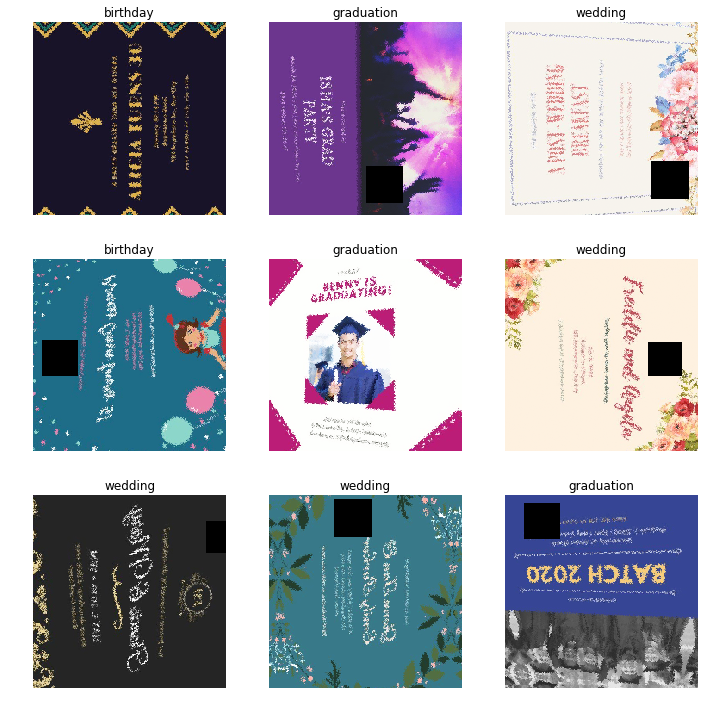

In [6]:
data.show_batch(rows=3, figsize=(10, 10))

This first step involves finding an optimal __learning rate__. The learning rate is a very important parameter that we set within the model.

There's some great articles that cover
[what the learning rate](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks) is as well as those that cover what the [1 Cycle Policy](https://medium.com/dsnet/the-1-cycle-policy-an-experiment-that-vanished-the-struggle-in-training-neural-nets-184417de23b9) is for training a model with a changing set of learning rates. So I won't go into detail on how it works, just a high-level overview of the steps below.

This first code block and plot helps us determine a maximum acceptable learning rate. I considered `1e-03` as a reasonable maximum. We want to keep well away from the sharp spike at `1e-01`. The original paper that introduced the 1 Cycle Policy ([link](https://arxiv.org/abs/1506.01186)) speaks of keeping your maximum learning rate at least an order of magnitude lower than the lowest point on your loss graph.

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03
Min loss divided by 10: 8.32E-03


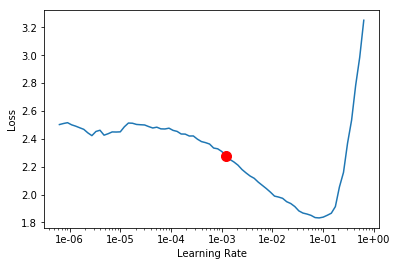

In [7]:
learn = cnn_learner(
    data,
    models.resnet34,
    metrics=metrics.error_rate
)
learn.model_dir = "/kaggle/working/model"

learn.lr_find()
learn.recorder.plot(suggestion=True)

First, we fit the model with the 1Cycle policy over 8 epochs.

In [8]:
lr = 1e-03
learn.fit_one_cycle(8, max_lr=lr)

learn.save('stage-1')

## How well does the model perform?

With the model trained. We can investigate how well it is performing. It is important to note that
a high accuracy classification model isn't _necessary_ for us to generate our recommender system.
We only care about the second-last step that contains the feature vector. However, the higher
the accuracy the more confidence we can have that
the model is focusing on the right features.

We can plot the confusion matrix of the model. To compare what it is predicting versus
the true labels. It seems that there's a lot of overlap with birthdays and weddings.
This checks out as there's lots of shared design elements between the wedding
and birthday graphics that are present in the data (floral wreaths are a popular
design element for both). Strangely there's also cross-over with bbq's and graduations.

The model is performing as can be expected with so few samples and lots of overlap
in the classes. Let's continue.

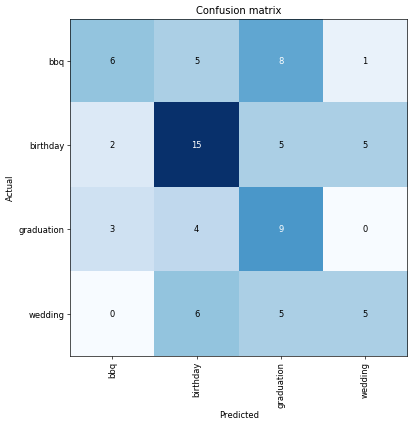

In [10]:
interp.plot_confusion_matrix(figsize=(7, 7), dpi=60)

Plotted below is the worst predictions. The heatmap shows us what the model
is focussing on in making its prediction. We can see that the model can sometimes
make its decisions based on a very small element of the graphic. For example a certain font points it to a certain category, or stars suggesting birthdays, large sans-serif text meaning bbqs or a floral wreath suggesting a wedding invitation.

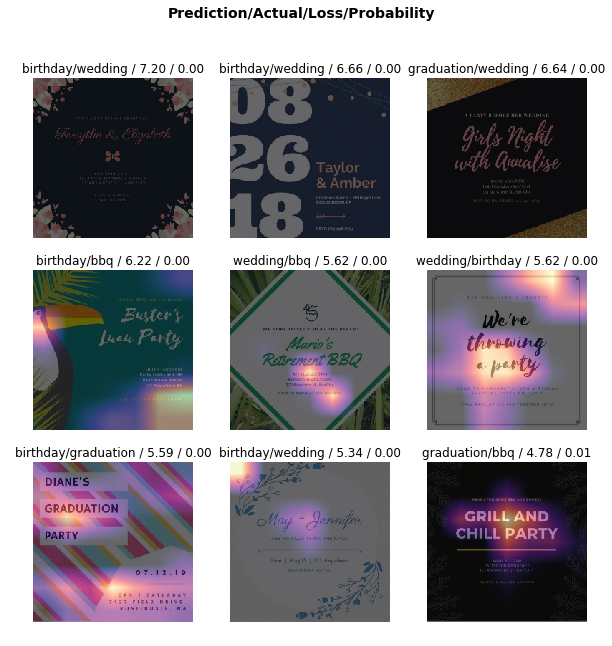

In [9]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_top_losses(9, figsize=(10, 10), heatmap=True)

## Let's generate our feature vectors!

This next step (credit to the kaggle notebook I linked above) is the extracting of the feature
vectors.

In [11]:
class SaveFeatures():
    """
    Source: https://www.kaggle.com/abhikjha/fastai-hooks-and-image-similarity-search
    """
    features=None
    
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
        
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
            
    def remove(self): 
        self.hook.remove()

In [12]:
sf = SaveFeatures(learn.model[-1][4])

_ = learn.get_preds(data.train_ds)
_ = learn.get_preds(DatasetType.Valid)

In [13]:
repr_length = sf.features.shape[1]
print(repr_length)

512


This has produced a vector of length 512 for _every_ image.
This can be thought of as a point in space (except with 512 dimensions!)
This vector means we can figure out how __semantically__ different
two images are by calculating the __distance__ between their two vector representations.

We can see below a table of the images with their vector representations.

In [14]:
all_images = list(data.train_ds.items) + list(data.valid_ds.items)

image_repr = pd.DataFrame({
    "image": [str(image) for image in all_images],
    "repr": sf.features.tolist()
})

image_repr.head()

image  \
0  /kaggle/input/invitations_all/wedding_canva-bl...   
1  /kaggle/input/invitations_all/birthday_canva-w...   
2  /kaggle/input/invitations_all/wedding_canva-bl...   
3  /kaggle/input/invitations_all/wedding_canva-gr...   
4  /kaggle/input/invitations_all/birthday_canva-m...   

                                                repr  
0  [-0.29472965002059937, -0.221747025847435, 0.7...  
1  [1.0146760940551758, 0.7876654863357544, -4.44...  
2  [-0.04942252114415169, -0.5496193170547485, 0....  
3  [-0.5791260004043579, -1.0852223634719849, -1....  
4  [-1.0069199800491333, 1.4881848096847534, -1.6...

In the naive case, finding similar images to any one chosen image involves comparing it against every other image available.
This is not ideal. I can't imagine a user is willing to sit around to wait for this to happen. The type of algorithm I describe here is about finding the $K$ nearest _neighbours_ to the image you are interested in (where $K$ is some number, say you wanted to find the top-5 most similar images). There is an approach called __Approximate Nearest Neighbours__. It trades off some accuracy (it may not return the _actual_ top-5 neighbours, they could be more like the top-(5 to 10)) to get a quicker runtime.

There is a wonderful package called [Annoy](https://github.com/spotify/annoy) (Approximate Nearest Neighbours Oh Yeah) which nicely implements this algorithm in Python. We use it as the backend process to return similar images quickly.

In [15]:
annoy_index = AnnoyIndex(repr_length, metric='euclidean')

for i, vector in enumerate(image_repr["repr"]):
    annoy_index.add_item(i, vector)
    
_ = annoy_index.build(50)

In [16]:
def get_similar_images_df(img_index: str, annoy: AnnoyIndex, 
                          repr_df: pd.DataFrame, n: int = 9):
    img_id = repr_df.iloc[img_index, 0]
    
    # the first result will be itself, so we search for n + 1` and remove `img_index` from the results
    similar_img_ids = annoy.get_nns_by_item(img_index, n + 1)
    similar_img_ids.remove(img_index)
    
    return img_id, repr_df.iloc[similar_img_ids]


def random_int(min: int, max: int, exclusions: Set[int]):
    while True:
        index = np.random.randint(min, max, 1)[0]
        if index not in exclusions:
            break
    return index


def show_comparison(n: int, annoy: AnnoyIndex, repr_df: pd.DataFrame, comparisons: int = 5):
    """
    We randomly select `n` images to find their comparisons.
    
    To get a reasonable range of images we ensure their aren't repeats between any of the `n` images,
    and their nearest neighbours.
    """
    indices = np.random.randint(0, repr_df.shape[0], n)
    
    used_indices = set()
    axes = subplots(rows=n, cols=comparisons + 1, imgsize=4)
    for axes_row in axes:
        img_index = random_int(0, repr_df.shape[0], exclusions=used_indices)
        base_image, similar_images_df = get_similar_images_df(img_index, annoy, repr_df)
        
        used_indices.add(img_index)
        used_indices.update(set(similar_images_df.index))

        open_image(base_image).show(ax=axes_row[0], title="Input image")        
        comparison_images = [open_image(image) for image in similar_images_df["image"]]
        
        for i, img, axes_col in zip(range(1, len(comparison_images) + 1), comparison_images, axes_row[1:]):
            img.show(ax=axes_col, title=f"Closest {i}")
    plt.tight_layout()

# The Results <a name="results"></a>

Let's take a look at how the model performed. Each row is one lot of suggestions. The first column in each row contains the input image and the rest are the top suggestions based on how similar they are. We can see that, for this small sample the results seem positive!

In the images below, I see commonalities across the row with:

- __Similar large layout effects__ (e.g. straight borders or floral wreaths)
- __Similar graphic design elements__ (e.g. forks + tongs, bbqs, large numerals, floral inserts, cursive fonts)

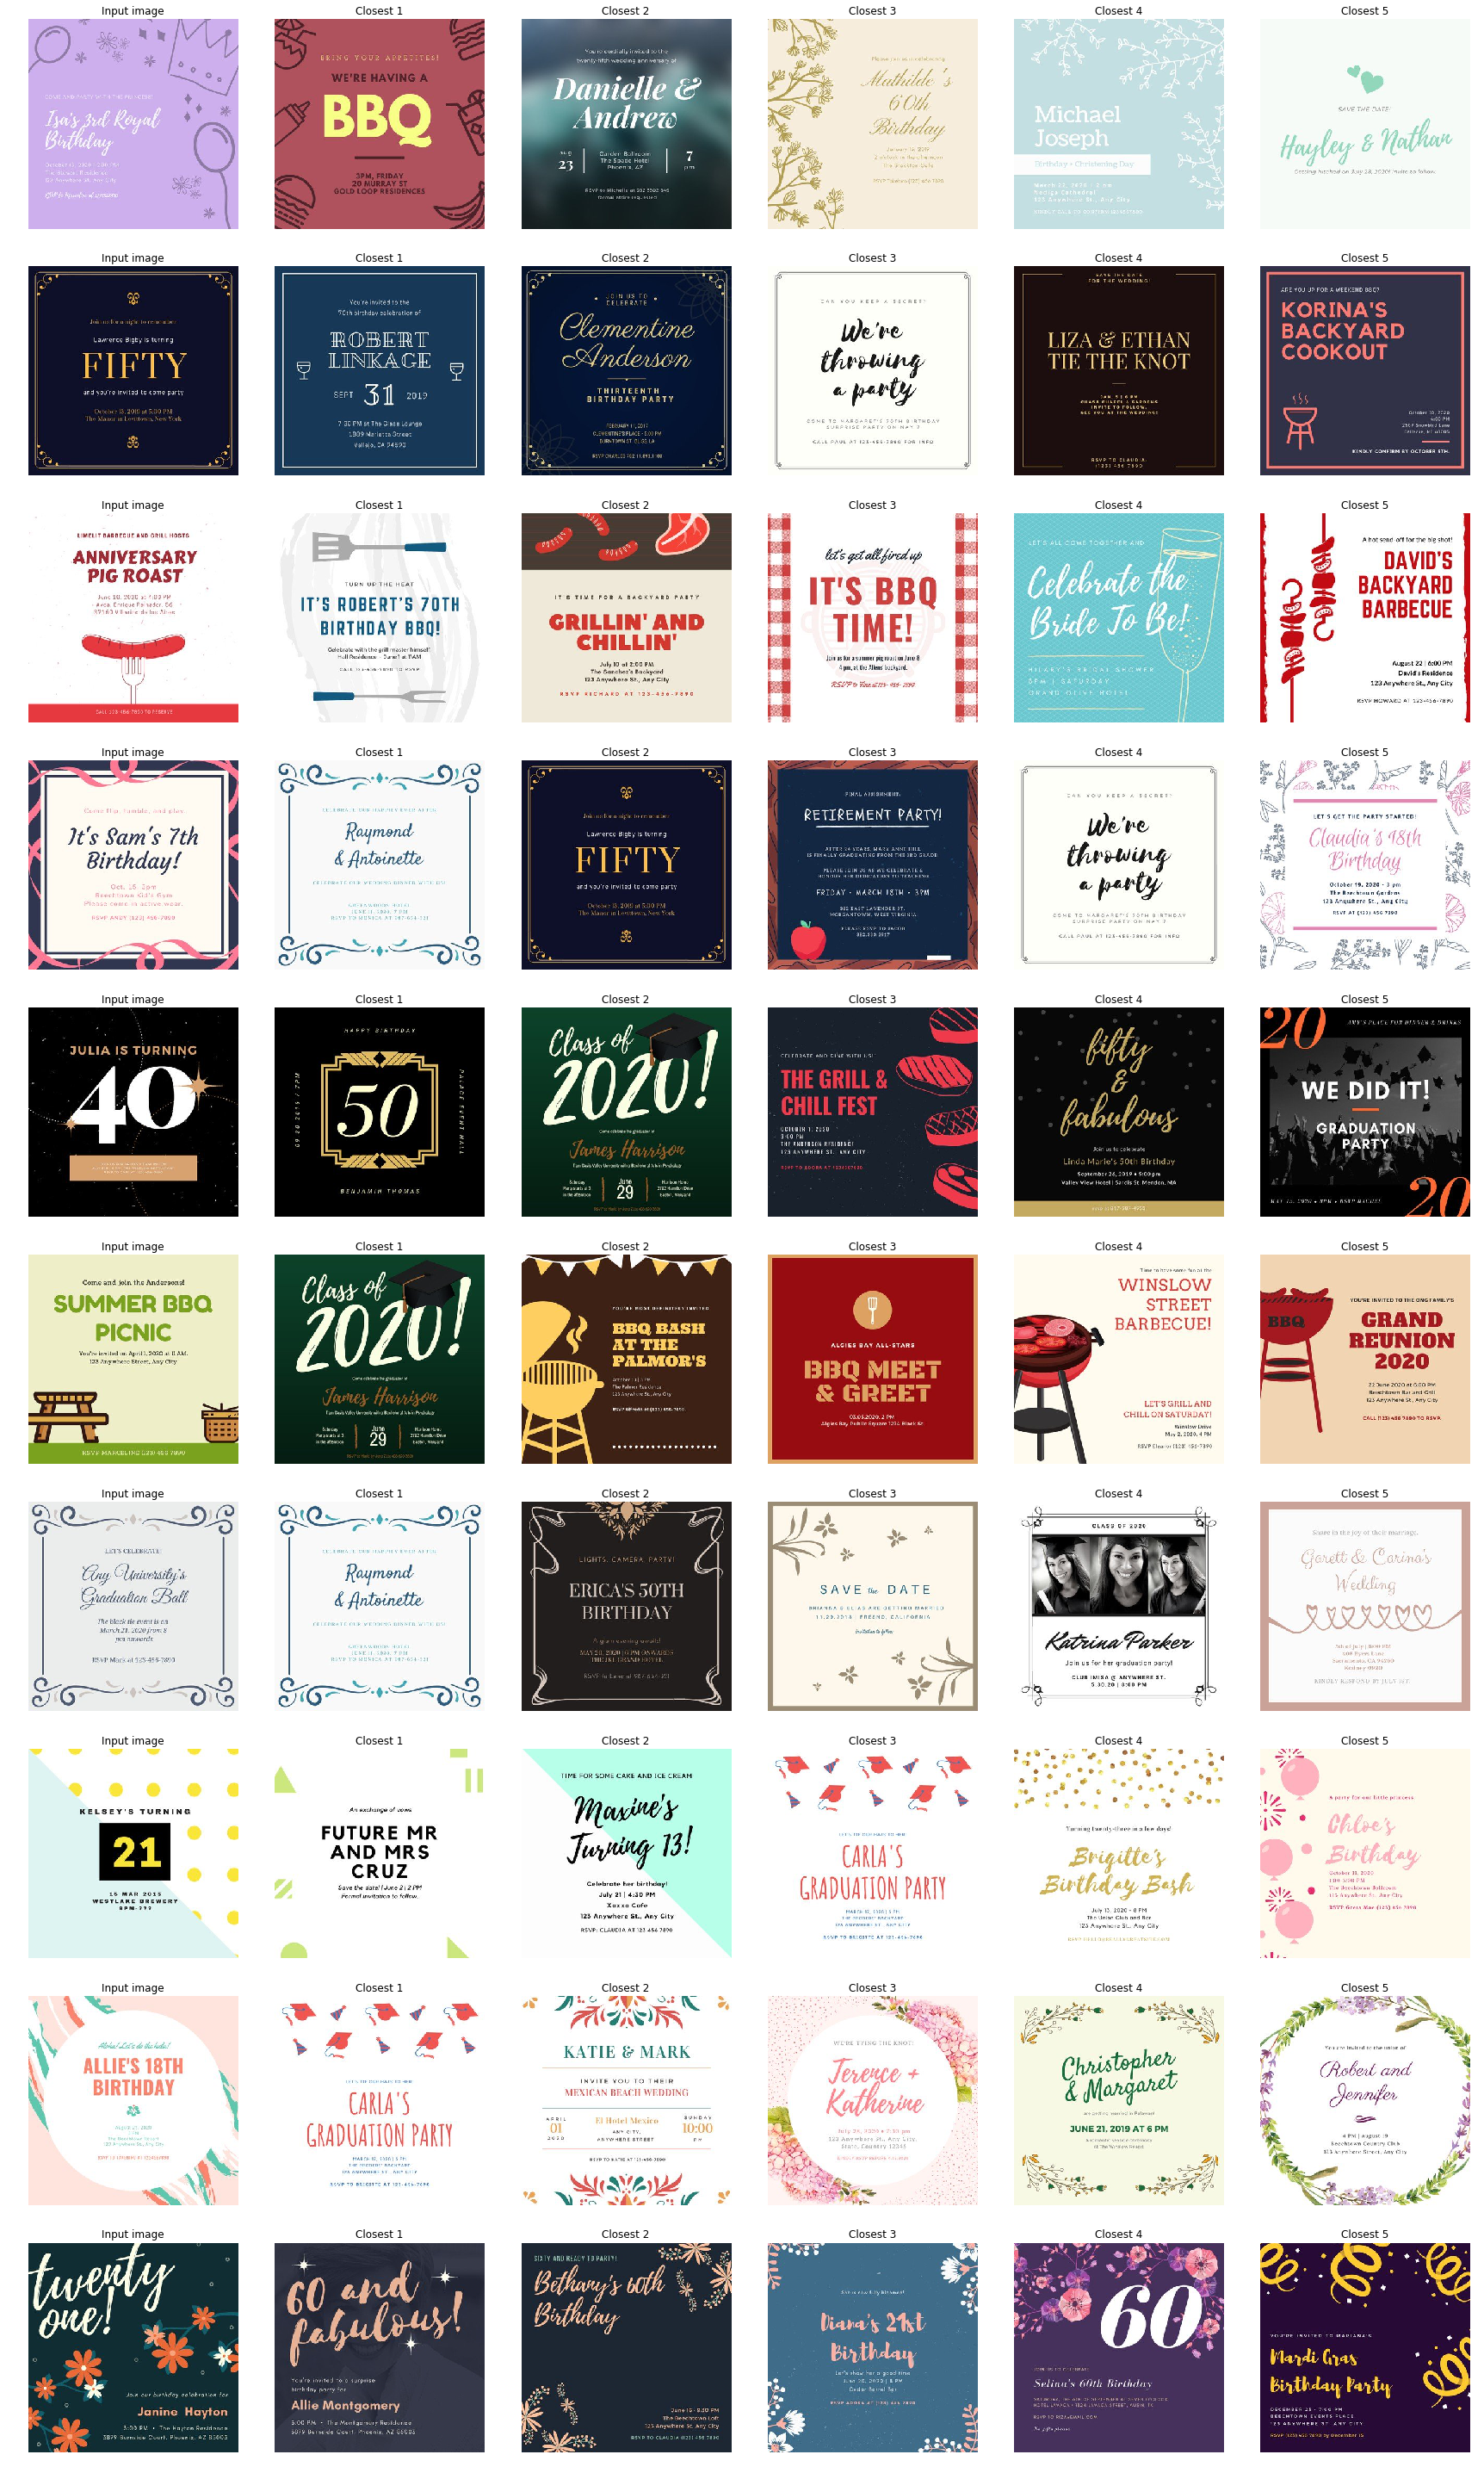

In [17]:
show_comparison(10, annoy_index, image_repr, comparisons=5)

# Where to from here

So how successful could this approach be in the graphic design template business? Well the proof is in the pudding. Can it increase the click-through rate of the `"Recommended for you"` section that is found on most websites? Hopefully. Can it increase customer satisfaction and ultimately improve customer numbers tenfold? Let's not get carried away. This would have to be tested on a website to see what short and long-term effects this sort of method might have.

How could this approach be further improved?

- Increase the amount of data trained on and available for querying. The quality of the similar images that can be served up can only be as good as the size of the storehouse of numeric features recorded. In a production setting you would imagine a  company would generate these numeric features on _all_ of their designs.
- Can this black-box approach be replaced with more interpretable features? Spotify tag their songs with a set of descriptive features that are inherently intepretable: the _acousticness_ of a song, or the _instrumentalness_ of a song. These are the features they use to find similar songs. With metadata on the individual graphic design elements, perhaps determining analgous features for a template would be achievable. I suspect there would be more business buy-in with more interpretable features.